In [37]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt 
import pennylane as qml
import pennylane.numpy as np 
from main.operators import *
from main.VarQFT import *
from main.circuits import *

In [38]:
num_wires = 2
dev = qml.device( "default.qubit", 
                    wires=2*num_wires, shots=100)

In [39]:
var_state = RY_ansatz( num_wires, 2 )
num_params = var_state.num_params
params     = np.zeros(num_params)
init_state = var_state.construct_circuit

In [40]:
X1, P1 = X_and_P_ops( range(num_wires), -5, 5, True )    
X2, P2 = X_and_P_ops( range(num_wires,2*num_wires), -5, 5, True )    

H12 = [ 
        X1.pow(2),
        X2.pow(2),
        P1.pow(2),
        P2.pow(2),
        qml.prod( X1, X2 )
        ]
H12 

[<Hamiltonian: terms=1, wires=[0, 1]>,
 <Hamiltonian: terms=1, wires=[2, 3]>,
 <Hamiltonian: terms=1, wires=[0, 1]>,
 <Hamiltonian: terms=1, wires=[2, 3]>,
   (1) [Hermitian0,1] @   (1) [Hermitian2,3]]

In [41]:
H_kron = 0
for h in H12[:1]:
    # try:
        h_wires  = list(h.wires)
        print( h.matrix() )
        h_matrix = np.kron( h.matrix(), np.eye( 2**(2*num_wires-len(h_wires)) ) )
        H_kron   = h_matrix.transpose(h_wires)
    # except:
    #     h_kron = 1
    #     for h_idx in h.operands:
    #         h_kron = np.kron( h_kron, h_idx.matrix() )

[[25.          0.          0.          0.        ]
 [ 0.          2.77777778  0.          0.        ]
 [ 0.          0.          2.77777778  0.        ]
 [ 0.          0.          0.         25.        ]]


In [42]:
h_matrix.shape 

(16, 16)

In [43]:
exp_val_XP( params, init_state, H12,  dev ) 

75.66619829707354

In [44]:
qml.grad(exp_val_XP)( params, init_state, H12,  dev )

array([-0.2220661 , -0.2220661 ,  0.11103305, -0.2220661 ])

In [45]:
ortho_params = np.random.randn(num_params)
def ortho_state():
    init_state( ortho_params )

In [46]:
fidelity( params, init_state, [ ortho_state ],  dev ) 

(0.635654239808516,)

In [47]:
varqft = VarFourier( H12, 
                    dev, 
                    init_state, 
                    ortho_values = [1000],
                    ortho_params = [ortho_params],
                    ortho_circuits = [init_state], )

In [48]:
varqft.hamiltonia_eval(params)

75.66619829707354

In [49]:
varqft.ortho_eval(params)

tensor(635.65423981, requires_grad=True)

In [50]:
varqft.energy_eval(params)

tensor(1346.97467791, requires_grad=True)

In [51]:
varqft.energy_grad( params )

tensor([224.82770506, 275.19186906, 894.47755395, 224.82770506], requires_grad=True)

In [52]:
Params, Energies = varqft.run( params, max_iterations=100 )

Step:    100, Energy:    35.616462


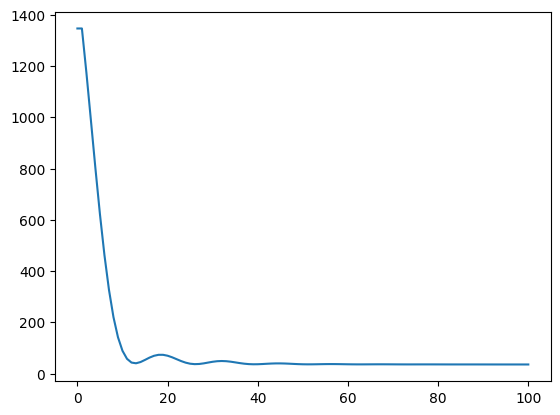

In [53]:
plt.plot( Energies )

In [62]:
def distance( X1, X2, tol=1e-6 ):
    wires = X1.wires+X2.wires
    eigvals1 = X1.eigvals()
    eigvals2 = X2.eigvals()
    eigvals = tol + np.kron(X1.eigvals(),np.ones_like(eigvals2)) \
                - np.kron(np.ones_like(eigvals1),X2.eigvals())
    return X_op( eigvals, wires )

In [63]:
distance( X1, X2 ).eigvals()

tensor([ 1.00000000e-06, -3.33333233e+00, -6.66666567e+00,
        -9.99999900e+00,  3.33333433e+00,  1.00000000e-06,
        -3.33333233e+00, -6.66666567e+00,  6.66666767e+00,
         3.33333433e+00,  1.00000000e-06, -3.33333233e+00,
         1.00000010e+01,  6.66666767e+00,  3.33333433e+00,
         1.00000000e-06], requires_grad=True)

In [64]:
distance( X1, X2 ).pow(-1).eigvals()

tensor([ 1.00000000e+06, -3.00000090e-01, -1.50000023e-01,
        -1.00000010e-01,  2.99999910e-01,  1.00000000e+06,
        -3.00000090e-01, -1.50000023e-01,  1.49999978e-01,
         2.99999910e-01,  1.00000000e+06, -3.00000090e-01,
         9.99999900e-02,  1.49999978e-01,  2.99999910e-01,
         1.00000000e+06], requires_grad=True)